In [9]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt  # Biblioteca para gerar gráficos
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn import metrics, model_selection, svm
from sklearn.ensemble import RandomForestClassifier
from scipy import stats
from scipy.spatial import distance
import math
import random


In [10]:

class Set:
    def __init__(self, dataset, features, output):
        self.dataset = dataset
        self.features = features
        self.output = output

    def get_n(self):
        return self.dataset.shape[0]

    def get_x(self):
        return self.dataset[:, self.features]
    
    def get_x_apply(self, func):
        return func(self.dataset[:, self.features])

    def set_x(self, new_x):
        self.x = new_x

    def get_y(self):
        return self.dataset[:, self.output]

    def get_X(self, func=None):
        if (func):
            return np.c_[np.ones(self.get_n()), func(self.get_x())]
        else:
            return np.c_[np.ones(self.get_n()), self.get_x()]


In [11]:
def is_true_positive(y, y_pred):
    return y_pred >= 1 and y >= 1

def is_false_positive(y, y_pred):
    return y_pred >= 1 and y <= 0

def is_true_negative(y, y_pred):
    return y_pred <= 0 and y <= 0

def is_false_negative(y, y_pred):
    return y_pred <= 0 and y >= 1

def confusion_matrix(y, y_pred):
    """ returns (tp, fp, tn, fn) """

    tp, fp, tn, fn = 0, 0, 0, 0
    for i, pred in enumerate(y_pred):
        tp += 1 if is_true_positive(y[i], pred) else 0
        fp += 1 if is_false_positive(y[i], pred) else 0
        tn += 1 if is_true_negative(y[i], pred) else 0
        fn += 1 if is_false_negative(y[i], pred) else 0
    return (tp, fp, tn, fn)

def accuracy(y, y_pred):
    tp, fp, tn, fn = confusion_matrix(y, y_pred)
    return (tp + tn) / (tp + fp + tn + fn)

def precision(y, y_pred):
    tp, fp, tn, fn = confusion_matrix(y, y_pred)
    return tp / (tp + fp)

def recall(y, y_pred):
    tp, fp, tn, fn = confusion_matrix(y, y_pred)
    return tp / (tp + fn)

def f1_score(y, y_pred):
    precision_ = precision(y, y_pred)
    recall_ = recall(y, y_pred)
    return 2 * (precision_ * recall_) / (precision_ + recall_)

def print_metrics(y_test, y_pred):
    print("acurácia: %.8f" % (accuracy(y_test, y_pred)))
    print("revocação: %.8f" % (precision(y_test, y_pred)))
    print("precisão: %.8f" % (recall(y_test, y_pred)))
    print("f1-score: %.8f" % (f1_score(y_test, y_pred)))
    print("")


# Questão 1

Considere o conjunto de dados disp onível em ``californiabin.csv``, organizado em 9 colunas, sendo as 8 primeiras colunas os atributos e a última coluna a saída. Os 8 atributos são usados na predição de preços de casas em distritos da Califórnia na década de 1990. A saída é binária: ``0`` para abaixo da mediana dos preços; ``1``, para acima da mediana dos preços. Maiores detalhes sobre os dados podem ser conferidos em https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset.

In [12]:
data = np.genfromtxt('./californiabin.csv', delimiter=',')
np.random.seed(666)
features = np.arange(8)
labels = 8

a) Considerando uma divisão de 70% dos padrões para treinamento e 30% para teste, avalie modelos de classificação binária nos dados em questão. Para tanto, use as abordagens abaixo:

- **SVM**: Escolha um *kernel* RBF e use *grid-search* para a justar os hiperparâmetros *C* (valores 2<sup>−5</sup>, 2<sup>−3</sup>, 2<sup>−1</sup>,..., 2<sup>11</sup>, 2<sup>13</sup>, 2<sup>15</sup>) e γ (valores
2<sup>−15</sup>, 2<sup>−13</sup> , 2<sup>−11</sup>, ... , 2<sup>1</sup>, 2<sup>2</sup>, 2<sup>3</sup>).

- **Random Forest**: Use *grid-search* para ajustar o número de classificadores base (valores 10, 20, ..., 180, 190, 200) e a máxima profundidade (*max depth*, valores 2, 4, 6, 8 ou máxima (None no sklearn)).

*(Use validações cruzadas em 10 folds no interior do grid-search.)*

In [13]:
data = Set(data, features, labels)
X = data.get_X(func=stats.zscore)
y = data.get_y()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
n_splits = 10

In [14]:
params = {
    'C' : np.logspace(-5, 15, num=15-5+1, base=2),
    'gamma': [2**-15, 2**-13, 2**-11, 2**-9, 2**-7, 2**-5, 2**-3, 2**-1, 2, 2**2, 2**3]
}
# params = {
#     'C': [2**-5, 2**-3],
#     'gamma': [2**-15, 2**-13],
# }
svm = svm.SVC(kernel='rbf')
grid_svm = GridSearchCV(svm, cv=n_splits, param_grid=params)
grid_svm.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': array([3.1250e-02, 1.2500e-01, 5.0000e-01, 2.0000e+00, 8.0000e+00,
       3.2000e+01, 1.2800e+02, 5.1200e+02, 2.0480e+03, 8.1920e+03,
       3.2768e+04]),
                         'gamma': [3.0517578125e-05, 0.0001220703125,
                                   0.00048828125, 0.001953125, 0.0078125,
                                   0.03125, 0.125, 0.5, 2, 4, 8]})

In [15]:
params = {
    'n_estimators' : np.arange(10, 210, step=10),
    'max_depth': [2, 4, 6, 8, None]
}
# params = {
#     'n_estimators' : [50, 200],
#     'max_depth': [2, 4, None]
# }
rfc = RandomForestClassifier()
grid_rfc = GridSearchCV(rfc, cv=n_splits, param_grid=params)
grid_rfc.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 4, 6, 8, None],
                         'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200])})

b) Para cada modelo, reporte os hiperparâmetros selecionados e as métricas de **acurácia**, **revocação**, **precisão** e **F1-score** nos dados de teste. Plote também a curva ROC e a **curva Precision-Recall** para cada modelo otimizado.


--- SVM
hiperparâmetros escolhidos: {'C': 128.0, 'gamma': 0.03125}
acurácia: 0.86000000
revocação: 0.84017279
precisão: 0.88208617
f1-score: 0.86061947



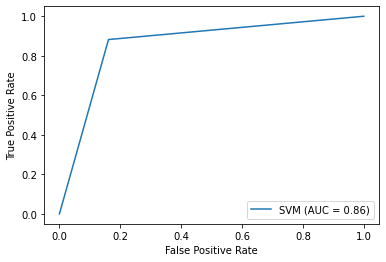

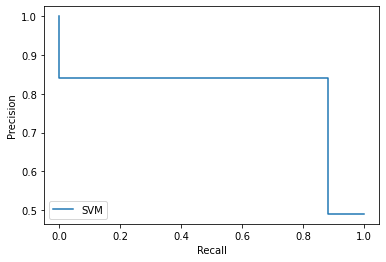

--- Random Forest
hiperparâmetros escolhidos: {'max_depth': None, 'n_estimators': 160}
acurácia: 0.89555556
revocação: 0.88300221
precisão: 0.90702948
f1-score: 0.89485459



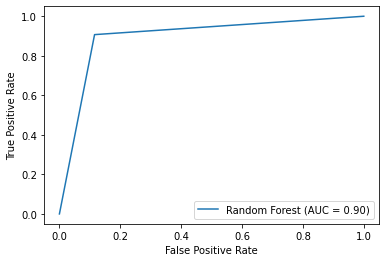

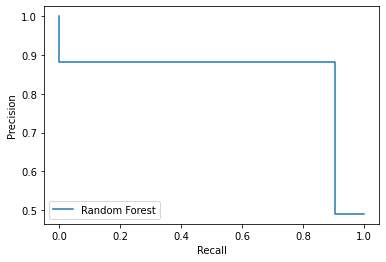

In [16]:
class Model:
    def __init__(self, name, inner):
        self.name = name
        self.inner = inner

models = [Model('SVM', grid_svm), Model('Random Forest', grid_rfc)]

for model in models:
    y_pred = model.inner.predict(X_test)

    print("--- %s" % (model.name))
    print("hiperparâmetros escolhidos: %s" % (model.inner.best_params_))
    print_metrics(y_test, y_pred)

    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=model.name)
    display.plot()
    plt.show()

    precision_, recall_, _ = metrics.precision_recall_curve(y_test, y_pred)
    display = metrics.PrecisionRecallDisplay(precision_, recall_, estimator_name=model.name)
    display.plot()
    plt.show()